In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time
!pip install keras-metrics
!pip install scikit-plot
!pip install scipy
import pandas as pd
import re
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from IPython.display import display
import keras_metrics
import keras
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
#import scikitplot as skplt
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
total_data = pd.read_csv("/content/drive/My Drive/cs224n project self/facts_opinions.csv")
total_data.head()

,Text,Label
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [4]:
def preproc(data):
  stopword=""
  cleantext = " "
  stopword = set(stopwords.words('english'))
  for i in word_tokenize(data):
    if(any(j.isdigit() for j in i)):
      continue
    i=i.lower()
    if (i not in stopword) and (len(i)>2):
      pattern1 = '[!.?$/\}#=<>"\*:,|_~;()^\']'
      pattern2 = '[\n\n]+'
      pattern3 = '[\ \ ]+'
      wout_sc = re.sub(pattern1,'',i)
      wout_el = re.sub(pattern2,'\n',wout_sc)
      wout_mspaces = re.sub(pattern3,' ',wout_el)
      cleaned_text = wout_mspaces.strip()
      cleaned_text=lemmatizer.lemmatize(cleaned_text)
      if (i not in stopword) and (len(i)>2):
        cleantext = cleantext+cleaned_text+" "
  return cleantext.strip()

In [5]:
for i in tqdm(range(len(total_data)),leave=True,position=0):
  total_data.iloc[i,0] = preproc(total_data.iloc[i,0])

100%|██████████| 94379/94379 [03:27<00:00, 455.26it/s] 


In [6]:
pickle_file_path = "/content/drive/My Drive/cs224n project self/facts_opinions.pkl"
total_data.to_pickle(pickle_file_path)

In [7]:
total_data.head()

,Text,Label
0,one reviewer mentioned watching episode ll hoo...,0
1,wonderful little production filming technique ...,0
2,thought wonderful way spend time hot summer we...,0
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,0


In [8]:
data_y = pd.DataFrame(data=total_data['Label'],columns=['Label'])
data_x = total_data.drop(columns="Label")

In [9]:
x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,train_size=0.9,random_state=42)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,train_size=0.9,random_state=42)

In [10]:
x_test.to_csv("/content/drive/My Drive/cs224n project self/x_test.csv",index=False)
y_test.to_csv("/content/drive/My Drive/cs224n project self/y_test.csv",index=False)

In [11]:
max_len=0
l=[]
index=[]
for i in range(len(x_train)):
  cur_len = len(x_train.iloc[i,0].split())
  if(cur_len>max_len):
    max_len=cur_len
print("Maximum length of sentence::",max_len)

Maximum length of sentence:: 1393


In [12]:
vocab={}
for i in tqdm(x_train['Text'],position=0,leave=True):
  for j in i.split():
    if j not in vocab:
      vocab[j]=1
    else:
      vocab[j]+=1
vocab = sorted(vocab, key=vocab.get, reverse=True)

100%|██████████| 76446/76446 [00:01<00:00, 41632.82it/s]


In [13]:
def vectorize(data,vocab):
  print("\nGenerating Vectors......")
  max_seq_len=1400
  row=0
  ## converting sequence to vector...
  new_data = pd.DataFrame(columns=["Text"])
  for i in tqdm(data['Text'],position=0,leave=True):
    sent=[]
    for j in i.split():
      try:
        sent.append((vocab.index(j))+1)
      except:
        continue
    new_data.loc[row] = [sent]
    row+=1
  new_data = sequence.pad_sequences(new_data['Text'], maxlen=max_seq_len)
  return new_data

In [14]:
x_train_vec = vectorize(x_train,vocab)
x_cv_vec = vectorize(x_cv,vocab)
x_test_vec = vectorize(x_test,vocab)


Generating Vectors......


100%|██████████| 76446/76446 [13:50<00:00, 92.02it/s]



Generating Vectors......


100%|██████████| 8495/8495 [01:40<00:00, 84.58it/s]



Generating Vectors......


100%|██████████| 9438/9438 [01:54<00:00, 82.61it/s]


In [15]:
import json
# Basic LSTM model with 0.01 learn rate and 1000 batch size
lstm_model1 = Sequential()
lstm_model1.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model1.add(LSTM(20))
lstm_model1.add(Dense(2, activation='softmax'))
checkpoint1 = ModelCheckpoint('/content/drive/My Drive/cs224n project self/saved models/model1analysis-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model1.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values1analysis=lstm_model1.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint1])
with open('/content/drive/My Drive/cs224n project self/saved models/lstm_model1analysis_history.json', 'w') as f:
    json.dump(values1analysis.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - acc: 0.8976 - loss: 0.2678
Epoch 1: val_loss improved from inf to 0.04227, saving model to /content/drive/My Drive/cs224n project self/saved models/model1analysis-001-0.959540-0.985874.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - acc: 0.8984 - loss: 0.2660 - val_acc: 0.9859 - val_loss: 0.0423
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - acc: 0.9925 - loss: 0.0275
Epoch 2: val_loss improved from 0.04227 to 0.03852, saving model to /content/drive/My Drive/cs224n project self/saved models/model1analysis-002-0.992792-0.988111.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - acc: 0.9925 - loss: 0.0275 - val_acc: 0.9881 - val_loss: 0.0385
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - acc: 0.9982 - loss: 0.0088
Epoch 3: val_loss did not improve from 0.03852
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - acc: 0.9982 - loss: 0.0088 - val_acc: 0.9830 - val_loss: 0.0647


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
# Assuming data_x['Text'] contains the original texts and y_cv contains the actual labels
# predictions is the list of predicted labels

predictions_prob = lstm_model1.predict(x_cv_vec)

# Convert probabilities to class labels (assuming binary classification)
predictions = np.argmax(predictions_prob, axis=1)

true_labels = y_cv.values

# Identify misclassified indices
misclassified_indices = [
    i for i in range(len(x_cv)) if predictions[i] != true_labels[i]
]

# Extract the original texts for misclassified examples
misclassified_texts = data_x.iloc[misclassified_indices]['Text']

# Perform n-gram analysis
def ngram_analysis(texts, n=2):
    """
    Analyze the most common n-grams in the given texts.
    Args:
        texts (iterable): Collection of text data.
        n (int): The size of n-grams to analyze.
    Returns:
        DataFrame: Most common n-grams with their counts.
    """
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=20, stop_words='english')
    X = vectorizer.fit_transform(texts)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()

    # Create a DataFrame of n-grams and their counts
    ngram_df = pd.DataFrame({
        'N-gram': ngram_features,
        'Count': ngram_counts
    }).sort_values(by='Count', ascending=False)

    return ngram_df

# Run unigram analysis (change `n` for other n-grams)
unigram_df = ngram_analysis(misclassified_texts, n=1)
sorted_unigram_df = unigram_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print("Most common unigrams in misclassified examples:")
print(sorted_unigram_df)

# Example: Save results to a CSV file
unigram_df.to_csv('/content/drive/My Drive/ngram_analysis_unigrams.csv', index=False)


# Run bigram analysis (change `n` for other n-grams)
bigram_df = ngram_analysis(misclassified_texts, n=2)
sorted_bigram_df = bigram_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print("Most common bigrams in misclassified examples:")
print(sorted_bigram_df)

# Example: Save results to a CSV file
bigram_df.to_csv('/content/drive/My Drive/ngram_analysis_bigrams.csv', index=False)

# Optional: Trigram analysis
trigram_df = ngram_analysis(misclassified_texts, n=3)
sorted_trigram_df = trigram_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print("Most common trigrams in misclassified examples:")
print(sorted_trigram_df)

# Save trigram results
trigram_df.to_csv('/content/drive/My Drive/ngram_analysis_trigrams.csv', index=False)


266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Most common unigrams in misclassified examples:
       N-gram  Count
0       movie    272
1        film    217
2          nt    161
3        good     96
4        like     86
5   character     84
6        time     74
7       story     73
8      really     57
9         bad     49
10        end     47
11      great     44
12       make     44
13     little     43
14      think     42
15       love     42
16      thing     42
17       best     39
18       look     39
19       year     38
Most common bigrams in misclassified examples:
             N-gram  Count
0           ve seen     12
1   barry champlain     11
2         look like     10
3       pretty good     10
4          movie nt     10
5          bug life      9
6          year old      7
7         end movie      6
8           nt want      6
9          nt think      6
10       like movie      6
11          film nt      6
12      acting good      5
13         new york      5
14    looking mov

266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


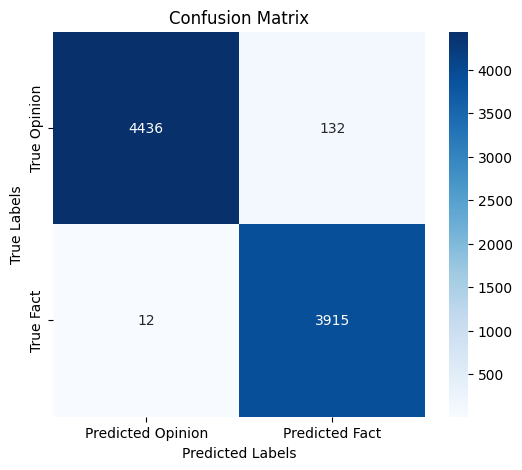

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make predictions on the validation data
predictions_prob = lstm_model1.predict(x_cv_vec)

# Step 2: Convert probabilities to class labels (assuming binary classification)
predictions = np.argmax(predictions_prob, axis=1)

# Step 3: Ensure y_cv is in the correct format
# If y_cv is one-hot encoded, convert it to class labels
true_labels = y_cv.values

# Step 4: Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Step 5: Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Opinion', 'Predicted Fact'], yticklabels=['True Opinion', 'True Fact'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [18]:
# add 2-3 different models for comparison and show a couple of wrongly classified examples
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(1 + len(vocab), 20, input_length=1400))
bi_lstm_model.add(Bidirectional(LSTM(20)))
bi_lstm_model.add(Dense(2, activation='softmax'))

checkpoint1 = ModelCheckpoint('/content/drive/My Drive/cs224n project self/saved models/bi_model_lstm-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
bi_lstm_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])


values_bi=bi_lstm_model.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint1])
with open('/content/drive/My Drive/cs224n project self/saved models/bi_lstm_model_history.json', 'w') as f:
    json.dump(values_bi.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - acc: 0.8814 - loss: 0.3065
Epoch 1: val_loss improved from inf to 0.07875, saving model to /content/drive/My Drive/cs224n project self/saved models/bi_model_lstm-001-0.946158-0.978222.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - acc: 0.8822 - loss: 0.3048 - val_acc: 0.9782 - val_loss: 0.0788
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - acc: 0.9868 - loss: 0.0504
Epoch 2: val_loss improved from 0.07875 to 0.04329, saving model to /content/drive/My Drive/cs224n project self/saved models/bi_model_lstm-002-0.987835-0.986345.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - acc: 0.9868 - loss: 0.0503 - val_acc: 0.9863 - val_loss: 0.0433
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - acc: 0.9953 - loss: 0.0204
Epoch 3: val_loss did not improve from 0.04329
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - acc: 0.9953 - loss: 0.0204 - val_acc: 0.9859 - val_loss: 0.0497


In [19]:
stack_lstm_model = Sequential()
stack_lstm_model.add(Embedding(1 + len(vocab), 20, input_length=1400))
stack_lstm_model.add(LSTM(50, return_sequences=True))
stack_lstm_model.add(LSTM(20))
stack_lstm_model.add(Dense(2, activation='softmax'))

checkpoint1 = ModelCheckpoint('/content/drive/My Drive/cs224n project self/saved models/stack_model_lstm-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

stack_lstm_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])

values_stack=stack_lstm_model.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint1])
with open('/content/drive/My Drive/cs224n project self/saved models/stack_lstm_model_history.json', 'w') as f:
    json.dump(values_stack.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - acc: 0.9030 - loss: 0.2646
Epoch 1: val_loss improved from inf to 0.04271, saving model to /content/drive/My Drive/cs224n project self/saved models/stack_model_lstm-001-0.956178-0.985285.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 303ms/step - acc: 0.9037 - loss: 0.2629 - val_acc: 0.9853 - val_loss: 0.0427
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - acc: 0.9932 - loss: 0.0246
Epoch 2: val_loss improved from 0.04271 to 0.03802, saving model to /content/drive/My Drive/cs224n project self/saved models/stack_model_lstm-002-0.993015-0.987758.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 295ms/step - acc: 0.9932 - loss: 0.0246 - val_acc: 0.9878 - val_loss: 0.0380
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - acc: 0.9980 - loss: 0.0088
Epoch 3: val_loss did not improve from 0.03802
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 295ms/step - acc: 0.9980 - loss: 0.0089 - val_acc: 0.9883 - val_loss: 0.0454


In [20]:
drop_lstm_model = Sequential()
drop_lstm_model.add(Embedding(1+len(vocab),20,input_length=1400))
drop_lstm_model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
drop_lstm_model.add(Dense(2, activation='softmax'))

checkpoint1 = ModelCheckpoint('/content/drive/My Drive/cs224n project self/saved models/drop_lstm_model-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
drop_lstm_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values_drop=drop_lstm_model.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint1])
with open('/content/drive/My Drive/cs224n project self/saved models/drop_lstm_history.json', 'w') as f:
    json.dump(values1analysis.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.8798 - loss: 0.3050
Epoch 1: val_loss improved from inf to 0.06664, saving model to /content/drive/My Drive/cs224n project self/saved models/drop_lstm_model-001-0.940533-0.981754.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 381s 5s/step - acc: 0.8806 - loss: 0.3035 - val_acc: 0.9818 - val_loss: 0.0666
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.9837 - loss: 0.0597
Epoch 2: val_loss improved from 0.06664 to 0.05035, saving model to /content/drive/My Drive/cs224n project self/saved models/drop_lstm_model-002-0.985676-0.984932.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 367s 5s/step - acc: 0.9837 - loss: 0.0596 - val_acc: 0.9849 - val_loss: 0.0503
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.9908 - loss: 0.0337
Epoch 3: val_loss improved from 0.05035 to 0.04394, saving model to /content/drive/My Drive/cs224n project self/saved models/drop_lstm_model-003-0.990333-0.985874.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 366s 5s/step - acc: 0.9908 

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred_prob = lstm_model1.predict(x_cv_vec)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_cv


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Validation Accuracy: 0.9830
Validation Precision: 0.9674
Validation Recall: 0.9969
Validation F1 Score: 0.9819


In [22]:
y_pred_prob = bi_lstm_model.predict(x_cv_vec)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_cv


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
Validation Accuracy: 0.9859
Validation Precision: 0.9818
Validation Recall: 0.9878
Validation F1 Score: 0.9848


In [23]:
y_pred_prob = stack_lstm_model.predict(x_cv_vec)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_cv


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step
Validation Accuracy: 0.9883
Validation Precision: 0.9846
Validation Recall: 0.9903
Validation F1 Score: 0.9874


In [24]:
y_pred_prob = drop_lstm_model.predict(x_cv_vec)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_cv


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

266/266 ━━━━━━━━━━━━━━━━━━━━ 200s 749ms/step
Validation Accuracy: 0.9859
Validation Precision: 0.9796
Validation Recall: 0.9901
Validation F1 Score: 0.9848
